## Introduction


<div style="font-family:verdana; word-spacing:1.7px;">
    Developing a GAN for gener- ating images requires both a discriminator convolutional neural network model for classifying whether a given image is real or generated and a generator model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values.   
<br><br>
Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality. Class labels can also be used for the deliberate or targeted generation of images of a given type.
<br><br>
A GAN can be trained in such a way that both the generator and the discriminator models are conditioned on the class label. This means that when the trained generator model is used as a standalone model to generate images in the domain, images of a given type, or class label, can be generated.

</div>



### 1. Importing Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import matplotlib.pyplot as plt

from PIL import Image
from keras.datasets import fashion_mnist

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Embedding
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Concatenate

from keras.utils import plot_model




import tensorflow as tf
from tensorflow import keras
print("TensorFlow version:", tf.__version__)
gpu_device_name = tf.test.gpu_device_name()
if gpu_device_name:
 print("GPU device name:", gpu_device_name)
else:
 print("No GPU found.")

0it [00:00, ?it/s]

TensorFlow version: 2.15.0
No GPU found.


### 2. Loading & Exploring dataset

In [2]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
print('X - Shape', trainX.shape)

print('Y- Shape', trainy.shape)

print('Classes : ', np.unique(trainy))

X - Shape (60000, 28, 28)
Y- Shape (60000,)
Classes :  [0 1 2 3 4 5 6 7 8 9]


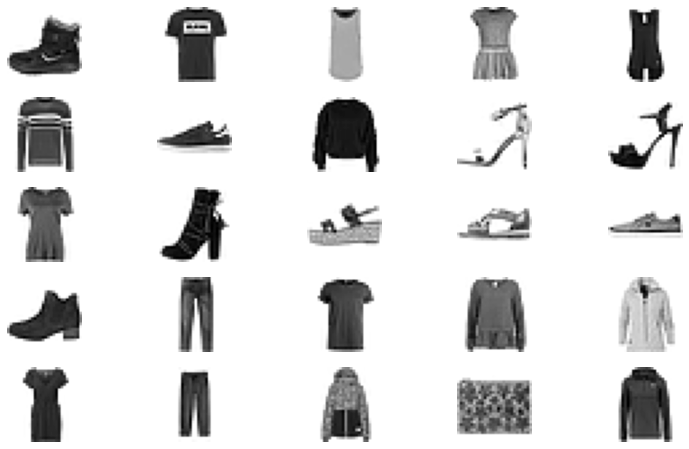

In [4]:
def plot_images(images, n):
    plt.figure(figsize=(13,8))
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i], cmap='gray_r')
    plt.show()

plot_images(trainX, 5)

### 3. Define Descriminator

<div style="font-family:verdana; word-spacing:1.7px;">
The class label is passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the Fashion-MNIST dataset (0 through 9) will map to a different 50-element vector representation that will be learned by the discriminator model. The output of the embedding is then passed to a fully connected layer with a linear activation.
    </div>

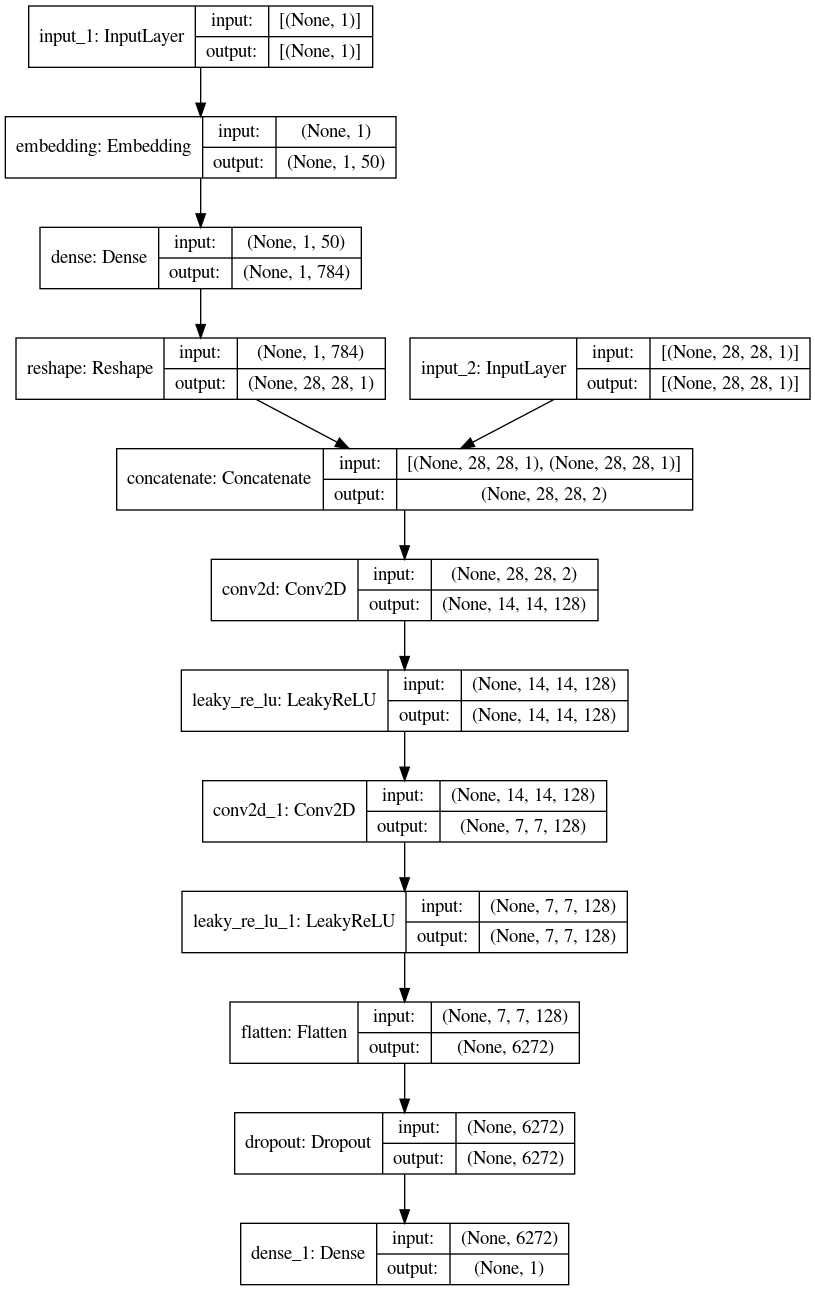

In [5]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    
    # Label Input
    in_label = Input(shape=(1,))    
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    
    
    # Image Input 28x28
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])
    
    # downsample 14x14
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # downsample 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    #Flatten Feature maps
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    
    out_layer = Dense(1, activation='sigmoid')(fe)
    
    model = Model([in_image, in_label], out_layer)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
    
    
discriminator = define_discriminator()
    
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

### 4. Define Generator
<div style="font-family:verdana; word-spacing:1.7px;">
    
 </div>

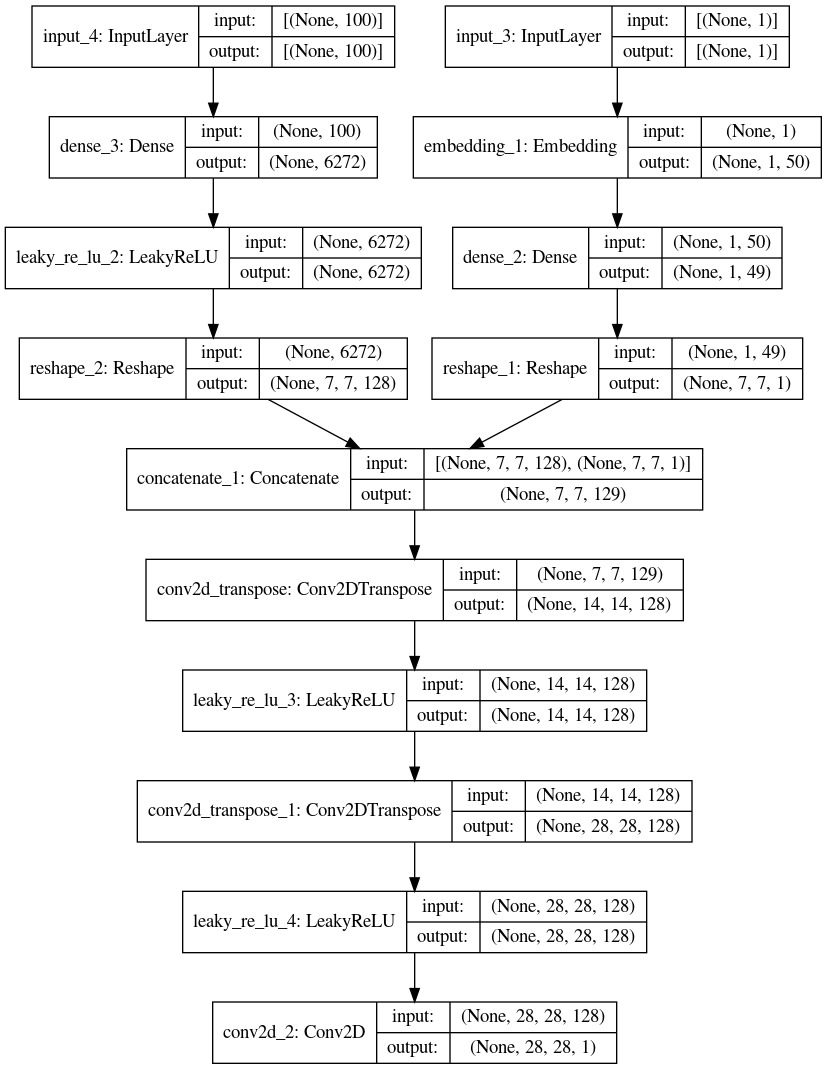

In [6]:
def define_generator(latent_dim, n_classes=10):
    
    # Label input
    in_label = Input(shape=(1,))
    
    li = Embedding(n_classes, 50)(in_label)
    
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    
    li = Reshape((7, 7, 1))(li)
    
    
    # Image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) 
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) 
    gen = LeakyReLU(alpha=0.2)(gen)
    
    
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    
    model = Model([in_lat, in_label], out_layer)
    return model

latent_dim = 100

generator = define_generator(latent_dim)

plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


### 5. Define GAN

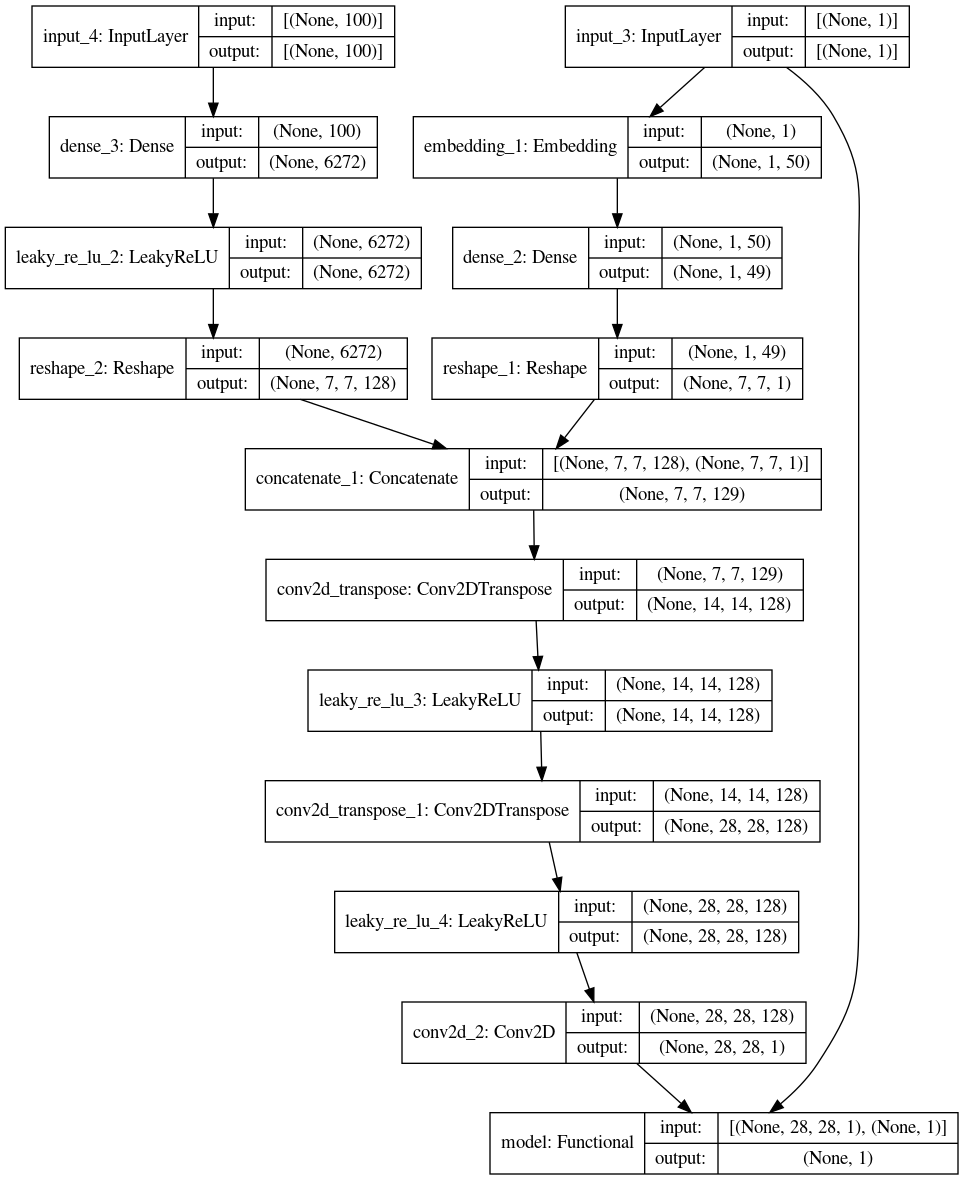

In [7]:
# define the combined generator and discriminator model, for updating the generator

def define_gan(generator, discriminator):
    discriminator.trainable = False
    
    gen_noise, gen_label = generator.input
    
    gen_output = generator.output
    
    
    # connect image output and label input from generator as inputs to discriminator
    gan_output = discriminator([gen_output, gen_label])
    
    model = Model([gen_noise, gen_label], gan_output)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

model = define_gan(generator, discriminator)

plot_model(model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

### 6. Generate Samples

In [8]:
print(trainX.shape)
print(np.expand_dims(trainX, axis=-1).shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [9]:
def load_real_samples():
    (trainX, trainy), (_, _) = fashion_mnist.load_data()
    
    X = np.expand_dims(trainX, axis=-1)
    
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    
    return [X, trainy]


def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], n_samples)
    
    X, labels = images[ix], labels[ix]
    
    y = np.ones((n_samples, 1))
    
    return [X, labels], y

In [10]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    
    labels = np.random.randint(0, n_classes, n_samples)
    return [x_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input, labels = generate_latent_points(latent_dim, n_samples)
    images = generator.predict([x_input, labels])
    
    y = np.zeros((n_samples, 1))
    
    return [images, labels], y

### 7. Train GAN

In [11]:
def save_plot(examples, epoch, n=10):
  # plot images
    plt.figure(figsize=(10,5))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i], cmap='gray_r')
        # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1) 
    plt.savefig(filename)
    plt.close()

def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
    [X_real, labels_real], y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = discriminator.evaluate([X_real, labels_real], y_real, verbose=0)
    
    [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    _, acc_fake = discriminator.evaluate([X_fake, labels], y_fake, verbose=0)

    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    save_plot(X_fake, epoch)
    
    # save model to file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    generator.save(filename)

In [12]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        g_losses, d_losses = list(), list()
        for j in range(bat_per_epo):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            
            #Train & Update Discriminator weights for real data
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)           
            
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            #Train & Update Discriminator weights for fake data
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            #X, y = np.vstack(([X_real, labels_real], [X_fake, labels])), np.vstack((y_real, y_fake))
            d_loss = (d_loss1 + d_loss2) / 2.0
            
            # prepare points in latent space as input for the generator
            [x_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([x_input, labels_input], y_gan)
            
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        print('>%d, d=%.3f, g=%.3f' % (i+1, np.mean(d_losses), np.mean(g_losses)))
        
        # evaluate the model every n_eval epochs
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [13]:
latent_points, labels = generate_latent_points(100, 100)

labels = np.asarray([x for _ in range(10) for x in range(10)])

discriminator = define_discriminator()

generator = define_generator(latent_dim)

gan_model = define_gan(generator, discriminator)

dataset = load_real_samples()

train(generator, discriminator, gan_model, dataset, latent_dim)

>1, d=0.642, g=0.824
>2, d=0.653, g=0.793
>3, d=0.669, g=0.772
>4, d=0.658, g=0.787
>5, d=0.662, g=0.787
>6, d=0.662, g=0.784
>7, d=0.658, g=0.790
>8, d=0.662, g=0.786
>9, d=0.665, g=0.781
>10, d=0.667, g=0.780
>Accuracy real: 63%, fake: 84%
>11, d=0.668, g=0.781
>12, d=0.669, g=0.781
>13, d=0.669, g=0.779
>14, d=0.670, g=0.778
>15, d=0.669, g=0.778
>16, d=0.668, g=0.783
>17, d=0.667, g=0.786
>18, d=0.668, g=0.786
>19, d=0.668, g=0.787
>20, d=0.670, g=0.781
>Accuracy real: 47%, fake: 80%
>21, d=0.671, g=0.779
>22, d=0.669, g=0.784
>23, d=0.670, g=0.787
>24, d=0.672, g=0.779
>25, d=0.671, g=0.784
>26, d=0.672, g=0.782
>27, d=0.672, g=0.782
>28, d=0.671, g=0.781
>29, d=0.673, g=0.781
>30, d=0.673, g=0.778
>Accuracy real: 56%, fake: 69%
>31, d=0.673, g=0.781
>32, d=0.672, g=0.781
>33, d=0.672, g=0.782
>34, d=0.671, g=0.781
>35, d=0.673, g=0.783
>36, d=0.674, g=0.778
>37, d=0.673, g=0.778
>38, d=0.673, g=0.781
>39, d=0.674, g=0.780
>40, d=0.674, g=0.779
>Accuracy real: 48%, fake: 60%
>41, 

### 8. Plot IMAGES vs Epochs

#### 1. After 10 Epochs</h4>

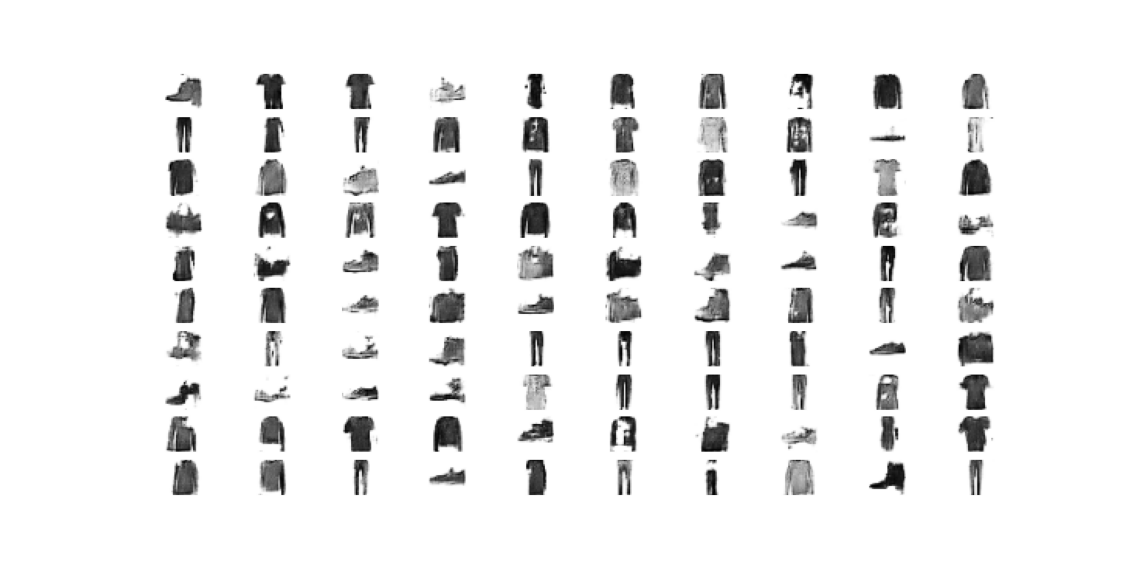

In [14]:
PATH = '/kaggle/input/output-data/'

plt.figure(figsize=(20,15))
plt.axis('off')

plt.imshow(plt.imread(PATH +'generated_plot_e010.png'))

#### 2. After 30 EPOCHS</h3>

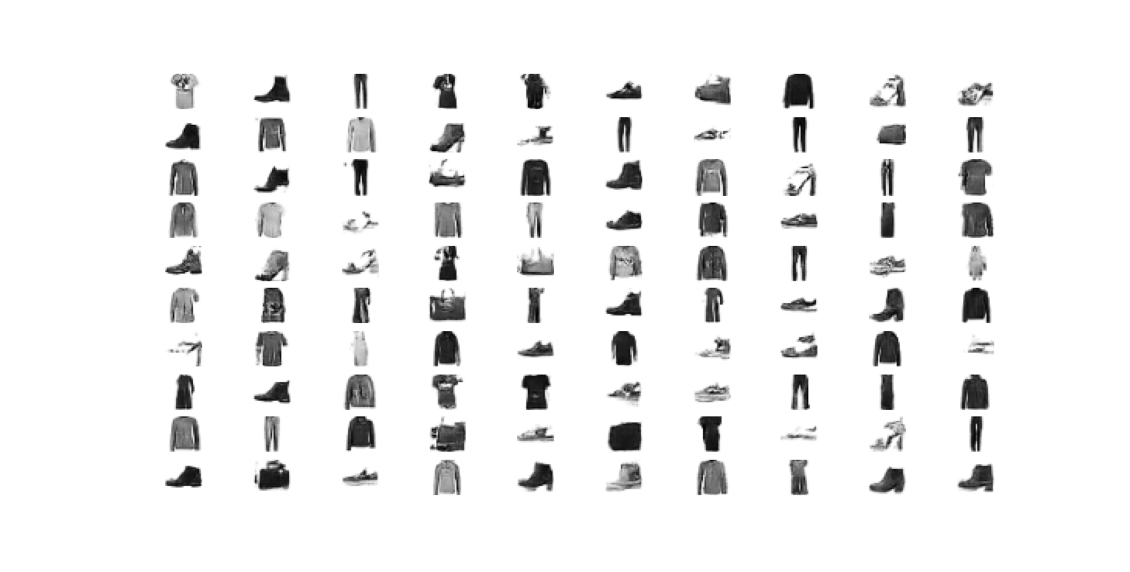

In [15]:
plt.figure(figsize=(20,15))
plt.axis('off')

plt.imshow(plt.imread(PATH +'generated_plot_e030.png'))

#### 3. After 100 EPOCHS</h3>

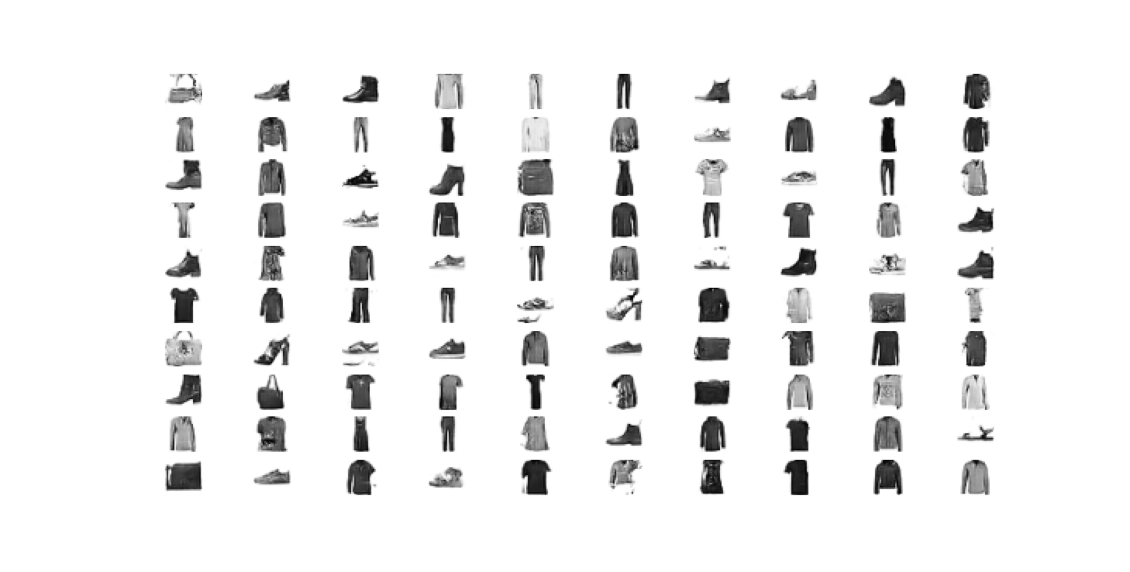

In [16]:
PATH = '/kaggle/input/output-data/'

plt.figure(figsize=(20,15))
plt.axis('off')

plt.imshow(plt.imread(PATH +'generated_plot_e100.png'))

### 8. Conditional Clothing Generation

In [17]:
def show_plot(examples, n=10):
  # plot images
    plt.figure(figsize=(30,20))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i], cmap='gray_r')
    plt.show()

In [18]:
np.asarray([x for _ in range(10) for x in range(10)])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

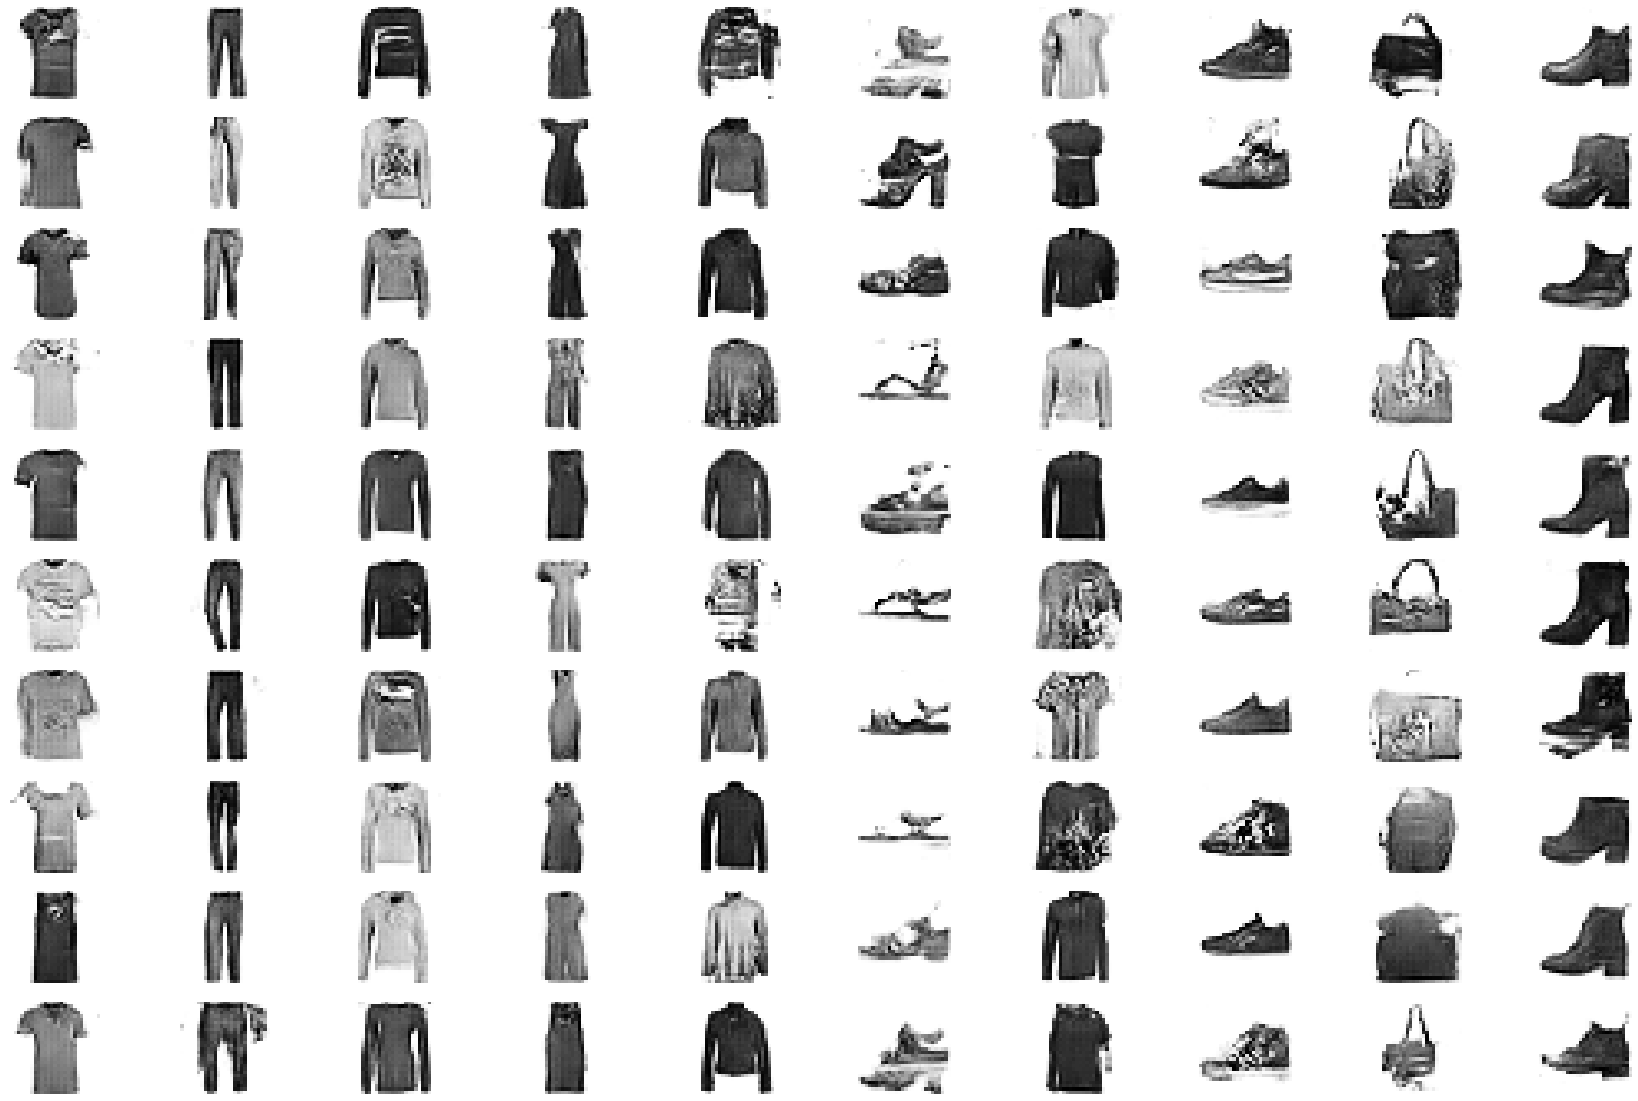

In [19]:
from keras.models import load_model

latent_points, labels = generate_latent_points(100, 100)

labels = np.asarray([x for _ in range(10) for x in range(10)])

model = load_model(PATH + 'generator_model_100.h5')

X = model.predict([latent_points, labels])


# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
show_plot(X, 10)

#### Full Sleeve Tshirt

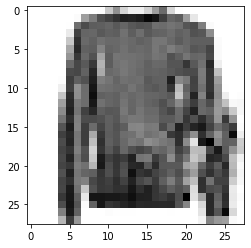

In [20]:
latent_points, labels = generate_latent_points(100, 1)
label = np.asarray([2])

X = model.predict([latent_points, label])


# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plt.imshow(X[0], cmap='gray_r')

#### Purse</h3>

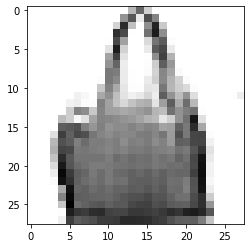

In [21]:
latent_points, labels = generate_latent_points(100, 1)

label = np.asarray([8])

X = model.predict([latent_points, label])


# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plt.imshow(X[0], cmap='gray_r')

#### Shoes

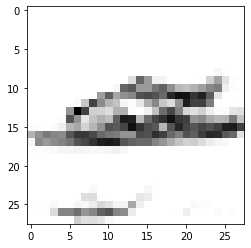

In [22]:
latent_points, labels = generate_latent_points(100, 1)

label = np.asarray([5])

X = model.predict([latent_points, label])


# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plt.imshow(X[0], cmap='gray_r')

In [8]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'results/CONDITIONAL_DCGAN_Fashion_Mnist_anim.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('results/generated*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

from IPython.display import Image
Image(url=anim_file)

C:\Users\hp\AppData\Local\Temp\ipykernel_23120\552673551.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\hp\AppData\Local\Temp\ipykernel_23120\552673551.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
